In [23]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from unidecode import unidecode

# Gensim
import gensim
from ast import literal_eval
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# nltk for stop words
import nltk
from nltk.corpus import stopwords

In [24]:
# traemos desde Textools, reemplazando sent_to_words

def to_unicode(column):
    if isinstance(column, list):
        column = pd.Series(column)
        column = column.apply(lambda x: unidecode(str(x)).lower())
        return column.values[0]
    if isinstance(column, pd.Series):
        column = column.apply(lambda x: unidecode(str(x)).lower())
        return column
    if isinstance(column, pd.DataFrame):
        for c in column.columns:
             column[c] = column[c].apply(lambda x: unidecode(str(x).lower()))
        return column
    return column

def tokenize(column):
    """ Tokenize a given column
    Args:
        column ([Serie]): a pandas column
    Return:
        a pandas column with tockens lists
    """
    def step(cell):
        # Remove special characters
        cell = unidecode(str(cell))
        # Lowercase
        cell = cell.lower()
        # Extract only words
        rfilter = r'[a-z]+'
        finds = re.findall(rfilter, cell)
        # Remove one-letters words
        finds = [f for f in finds if len(f)>1]
        # Remove stop words
        finds = [f for f in finds \
        if f not in stopwords.words('spanish')]
        if finds == ['nr'] or finds == [] or finds==['nan']:
            finds = 'NR'
        return finds

    assert isinstance(column, pd.Series), \
    'Column should be a pandas Serie. {} was received instead'.format(type(column))

    column = column.apply(lambda x: step(x))
    return column

In [25]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) # deacc=True removes punctuations
        yield(sent)          
        
        
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out  

In [26]:
# NLTK Stop words
stop_words = stopwords.words('spanish')

# Spacy fro NLP
# Initialize spacy 'es' model, keeping only tagger component (for efficiency)
# python3 -m spacy download 

#nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
#nlp = spacy.load('es_core_news_sm')
#nlp = spacy.load('es_core_news_lg')
nlp = spacy.load('es_dep_news_trf', disable=['parser', 'ner'])

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [27]:
#lectura de Archivo
df = pd.read_excel (r'D:\CMM\2021_model_MDS\necesidades.xlsx')
print(df.Necesidad.unique())
df.head()

['1 Mejores sueldos' '\tNOS SENTIMOS PASADOS A LLEVAR.'
 'Acceso a trabajos dignos, estables,' ...
 'Más derechos para madres adolescentes' '3- Que chile no sea capitalista'
 'Mejorar la salud públic']


,ORDEN,N,Necesidad
0,1,1,1 Mejores sueldos
1,2,1,\tNOS SENTIMOS PASADOS A LLEVAR.
2,3,1,"Acceso a trabajos dignos, estables,"
3,4,1,"salud,"
4,5,1,Mejorar el sistema de pensiones para los traba...


In [41]:
# Convert to list
data = df.Necesidad.values.tolist()

# otra opción de limpieza
#data_words = list(sent_to_words(data))
#print(data_words[:10])

# Opción de limpieza tomada
data_words = list(tokenize(to_unicode(df.Necesidad)))
print(data_words[:10])

[['mejores', 'sueldos'], ['sentimos', 'pasados', 'llevar'], ['acceso', 'trabajos', 'dignos', 'estables'], ['salud'], ['mejorar', 'sistema', 'pensiones', 'trabajadores', 'pais'], ['lejos', 'importancia', 'dan', 'pasar', 'mas', 'tiempo', 'familias', 'especialmente', 'papa', 'mama', 'principal', 'tema', 'senalado'], ['infraestructura', 'lugar', 'ejecutan', 'actividade'], ['equidad', 'genero'], ['equidad', 'genero'], ['personas', 'puedan', 'dialogar', 'necesidad', 'llegar', 'violencia']]


In [42]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=30)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram) 
print(trigram_mod[bigram_mod[data_words[0]]])

['mejores_sueldos']


In [43]:
data_lemmatized=process_words(data_words)   
print(data_lemmatized[:10])

[['mejores_sueldo'], ['sentir', 'pasado', 'llevar'], ['acceso', 'trabajo', 'digno', 'estable'], ['salud'], ['mejorar', 'sistema', 'pensión', 'trabajador', 'pais'], ['lejos', 'importancia', 'dar', 'pasar', 'mas', 'tiempo', 'familia', 'especialmente', 'papa', 'mama', 'principal', 'tema', 'senalado'], ['infraestructura', 'lugar', 'ejecutar', 'actividade'], ['equidad', 'genero'], ['equidad', 'genero'], ['persona', 'dialogar', 'necesidad', 'llegar', 'violencia']]


In [44]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('mejores_sueldo', 1)],
 [('llevar', 1), ('pasado', 1), ('sentir', 1)],
 [('acceso', 1), ('digno', 1), ('estable', 1), ('trabajo', 1)],
 [('salud', 1)],
 [('mejorar', 1),
  ('pais', 1),
  ('pensión', 1),
  ('sistema', 1),
  ('trabajador', 1)]]

# Build LDA model

In [61]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=128,
                                           passes=10,
                                           alpha='auto',
                                           eta='auto',
#                                           decay=0.5, 
#                                           distributed=True, 
#                                           alpha=0.01,
#                                           eta=0.1, 
                                           per_word_topics=True)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.083*"tener" + 0.073*"menos" + 0.037*"piscina" + 0.030*"juego" + '
  '0.028*"adulto" + 0.022*"parque" + 0.020*"caso" + 0.020*"problema" + '
  '0.019*"jugar" + 0.019*"gustaria"'),
 (1,
  '0.071*"nino" + 0.060*"chile" + 0.051*"derecho" + 0.035*"discriminacion" + '
  '0.030*"igualdad_genero" + 0.026*"ano" + 0.025*"universal" + 0.024*"justo" + '
  '0.023*"transporte" + 0.020*"miedo"'),
 (2,
  '0.095*"casa" + 0.093*"faltar" + 0.042*"seguridad" + 0.034*"recurso" + '
  '0.028*"quemen" + 0.027*"droga" + 0.027*"abuso" + 0.023*"dialogo" + '
  '0.018*"paz" + 0.018*"ausencia"'),
 (3,
  '0.057*"social" + 0.055*"gente" + 0.054*"trabajo" + 0.050*"familia" + '
  '0.047*"justicia" + 0.034*"dinero" + 0.032*"lugar" + 0.030*"tiempo" + '
  '0.025*"profesional" + 0.025*"madre"'),
 (4,
  '0.118*"mayor" + 0.076*"acceso" + 0.047*"politico" + 0.039*"agua" + '
  '0.034*"cambio" + 0.031*"padre" + 0.023*"compartir" + 0.022*"equidad" + '
  '0.021*"gustar" + 0.018*"ciudad"'),
 (5,
  '0.049*"joven" + 0.046*"

In [62]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.287251594756972

Coherence Score:  0.5792288062111799


# Visualize the topics

In [63]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.403103 -0.008298       1        1  16.544997
5      0.046808 -0.231294       2        1  13.980252
9      0.033419  0.315909       3        1  11.102924
0      0.041429 -0.009081       4        1   8.352463
3      0.039203 -0.009949       5        1   7.523969
6      0.041570 -0.009063       6        1   7.509790
1      0.040130 -0.010110       7        1   7.415702
8      0.038355 -0.010340       8        1   7.377250
4      0.039962 -0.009386       9        1   7.374151
10     0.042005 -0.008877      10        1   6.728343
2      0.040223 -0.009512      11        1   6.090158, topic_info=            Term        Freq       Total Category  logprob  loglift
20           mas  374.000000  374.000000  Default  30.0000  30.0000
51     educacion  276.000000  276.000000  Default  29.0000  29.0000
46         mayor  144.000000  144.000000  Default  28.0000  28.0000
8          salud  208.000000  208.000000  Default  27.0000  27.0000
36       persona  117.000000  117.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1327    invertir    8.214061    9.246405  Topic11  -4.8070   2.6801
421    deportivo    7.685615    8.717932  Topic11  -4.8735   2.6725
125      planeta    7.397777    8.430099  Topic11  -4.9117   2.6679
511       ultimo    7.101819    8.134211  Topic11  -4.9525   2.6628
1796  vigilancia    6.421553    7.454123  Topic11  -5.0532   2.6494

[360 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1375      2  0.966766     abandono
352       2  0.958127     abuelito
295       4  0.949314       abuelo
392      11  0.971646        abuso
1077      7  0.949771  abuso_poder
...     ...       ...          ...
37        8  0.994337    violencia
497       8  0.872399     violento
247       2  0.988766     vivienda
78        6  0.978393        vivir
293       9  0.908024         zona

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 10, 1, 4, 7, 2, 9, 5, 11, 3])

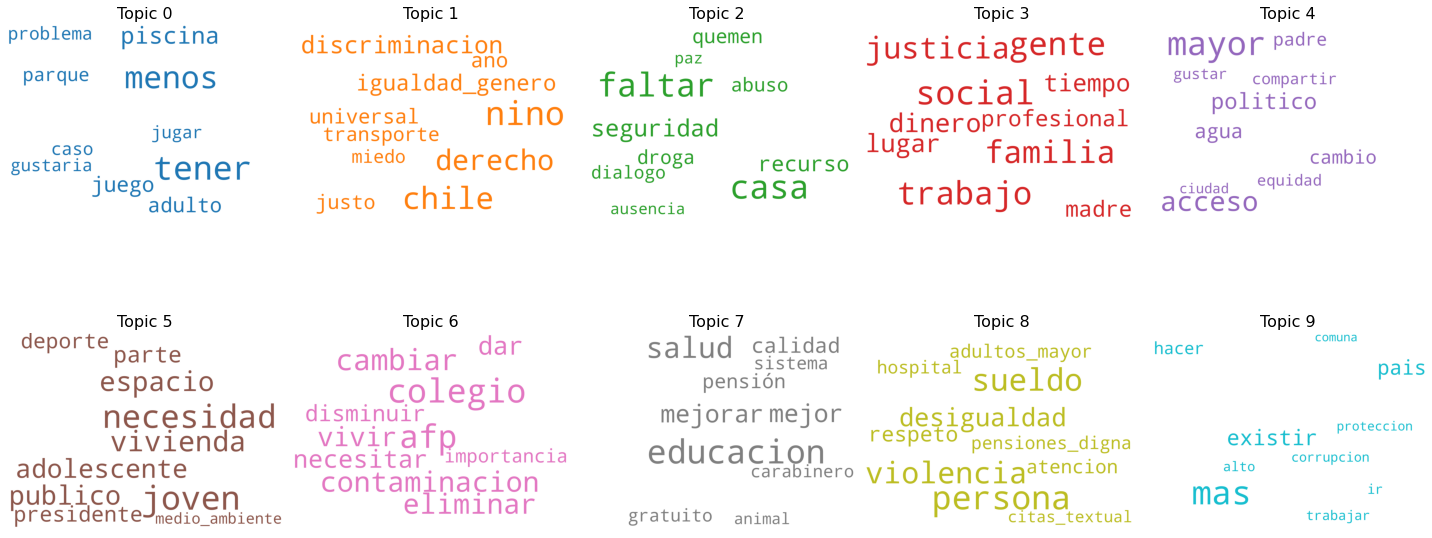

In [66]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(11,formatted=False)

fig, axes = plt.subplots(2,5, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Crear Tablas

In [85]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # 0 => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

data_ready=data_lemmatized
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
pd.DataFrame(df_dominant_topic, columns=['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']).to_excel("D:/CMM/2021_model_MDS/nna_nece"+ str(lda_model.num_topics) +".xlsx")
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.2198,"social, gente, trabajo, familia, justicia, dinero, lugar, tiempo, profesional, madre",[mejores_sueldo]
1,1,9.0,0.4040,"mas, existir, pais, hacer, ir, trabajar, alto, corrupcion, proteccion, comuna","[sentir, pasado, llevar]"
2,2,7.0,0.2046,"educacion, salud, mejor, mejorar, calidad, pensión, sistema, gratuito, carabinero, animal","[acceso, trabajo, digno, estable]"
3,3,7.0,0.2999,"educacion, salud, mejor, mejorar, calidad, pensión, sistema, gratuito, carabinero, animal",[salud]
4,4,7.0,0.4724,"educacion, salud, mejor, mejorar, calidad, pensión, sistema, gratuito, carabinero, animal","[mejorar, sistema, pensión, trabajador, pais]"
5,5,6.0,0.4247,"colegio, afp, cambiar, contaminacion, eliminar, vivir, dar, necesitar, disminuir, importancia","[lejos, importancia, dar, pasar, mas, tiempo, familia, especialmente, papa, mama, principal, tem..."
6,6,3.0,0.3275,"social, gente, trabajo, familia, justicia, dinero, lugar, tiempo, profesional, madre","[infraestructura, lugar, ejecutar, actividade]"
7,7,4.0,0.3228,"mayor, acceso, politico, agua, cambio, padre, compartir, equidad, gustar, ciudad","[equidad, genero]"
8,8,4.0,0.3228,"mayor, acceso, politico, agua, cambio, padre, compartir, equidad, gustar, ciudad","[equidad, genero]"
9,9,8.0,0.4210,"persona, sueldo, violencia, desigualdad, respeto, atencion, adultos_mayor, hospital, pensiones_d...","[persona, dialogar, necesidad, llegar, violencia]"


11

In [86]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
pd.DataFrame(sent_topics_sorteddf_mallet, columns=['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]).to_excel("D:/CMM/2021_model_MDS/nna_nece"+ str(lda_model.num_topics) +"_dts.xlsx")
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6115,"tener, menos, piscina, juego, adulto, parque, caso, problema, jugar, gustaria","[faltar, posibilidad, educacional, carrera, tecnica, cabido, arte, problema, entrar, universidad]"
1,1.0,0.4690,"nino, chile, derecho, discriminacion, igualdad_genero, ano, universal, justo, transporte, miedo","[falta, garantizacion, derecho, basico]"
2,2.0,0.4709,"casa, faltar, seguridad, recurso, quemen, droga, abuso, dialogo, paz, ausencia","[pais, tolerante, respeto, amor, paz, empatico, alegre, libre, respete, planeta]"
3,3.0,0.5871,"social, gente, trabajo, familia, justicia, dinero, lugar, tiempo, profesional, madre","[educacion, adolescente, demostrar, descontento, segregacion, existente, asimismo, acuerdo, merc..."
4,4.0,0.4969,"mayor, acceso, politico, agua, cambio, padre, compartir, equidad, gustar, ciudad","[agua, beber, nadar, casacada, cn, agua, casa, agua]"
5,5.0,0.6701,"joven, necesidad, vivienda, espacio, publico, adolescente, parte, presidente, deporte, medio_amb...","[cuanto, necesidad, manifestado, ninos_nina, indagar, respecto, falta, espacio, participacion, n..."
6,6.0,0.4847,"colegio, afp, cambiar, contaminacion, eliminar, vivir, dar, necesitar, disminuir, importancia","[faltar, espacio, adecuado, recreacion, colegio, sede, rural, necesidad, proteccion, medio_ambie..."
7,7.0,0.6121,"educacion, salud, mejor, mejorar, calidad, pensión, sistema, gratuito, carabinero, animal","[fiscalizacion, alimentacion, razon, vencimiento, correcto, manejo, sanitario, utensilio]"
8,8.0,0.4818,"persona, sueldo, violencia, desigualdad, respeto, atencion, adultos_mayor, hospital, pensiones_d...","[necesidad, adulto, llegar, acuerdo, lograr, entender, pelear, tratar, bien, respeto]"
9,9.0,0.6664,"mas, existir, pais, hacer, ir, trabajar, alto, corrupcion, proteccion, comuna","[mas, recalcar, querian, pais, mas, limpio, ensene, escuela, cultivar, huerta, existir, mas]"


# Más Gráficos

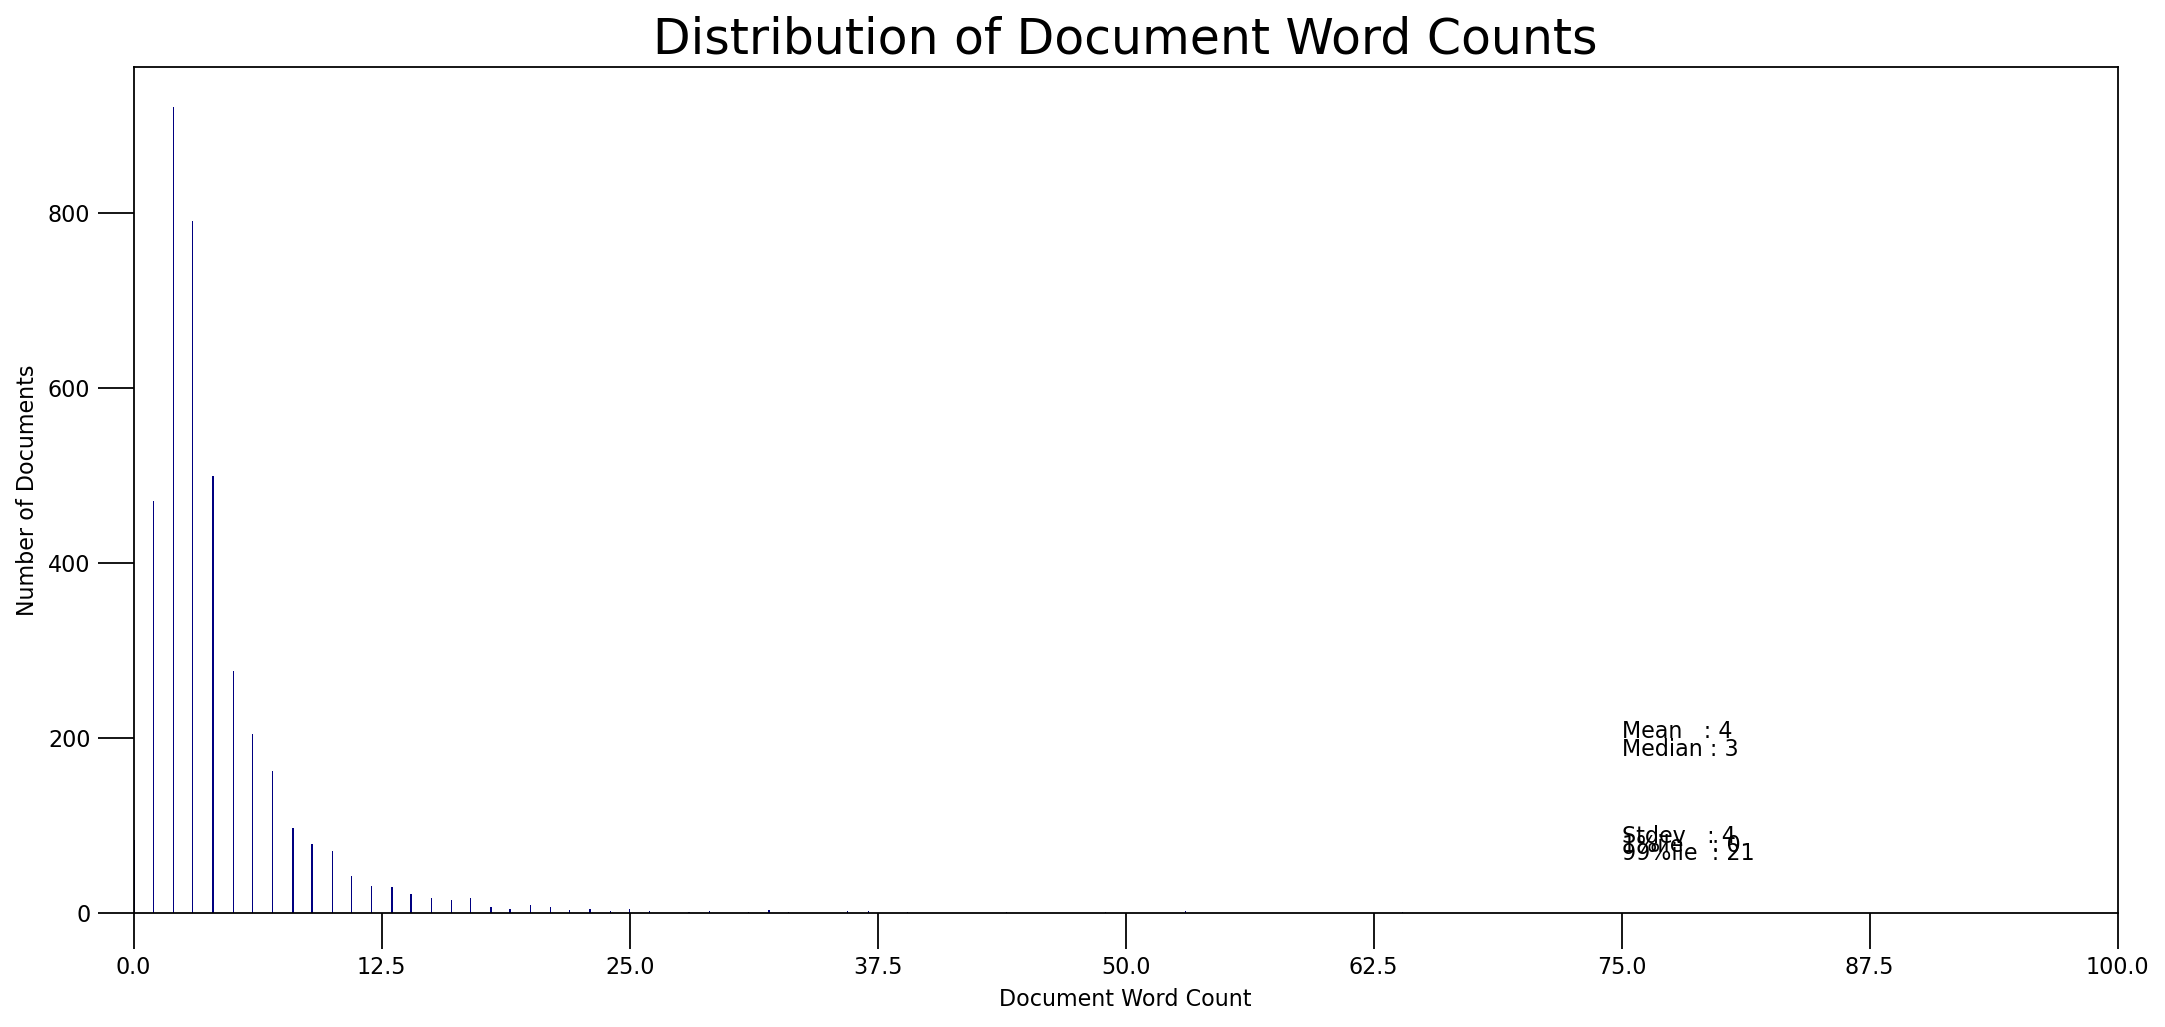

In [69]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(75, 200, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(75,  180, "Median : " + str(round(np.median(doc_lens))))
plt.text(75,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(75,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(75,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

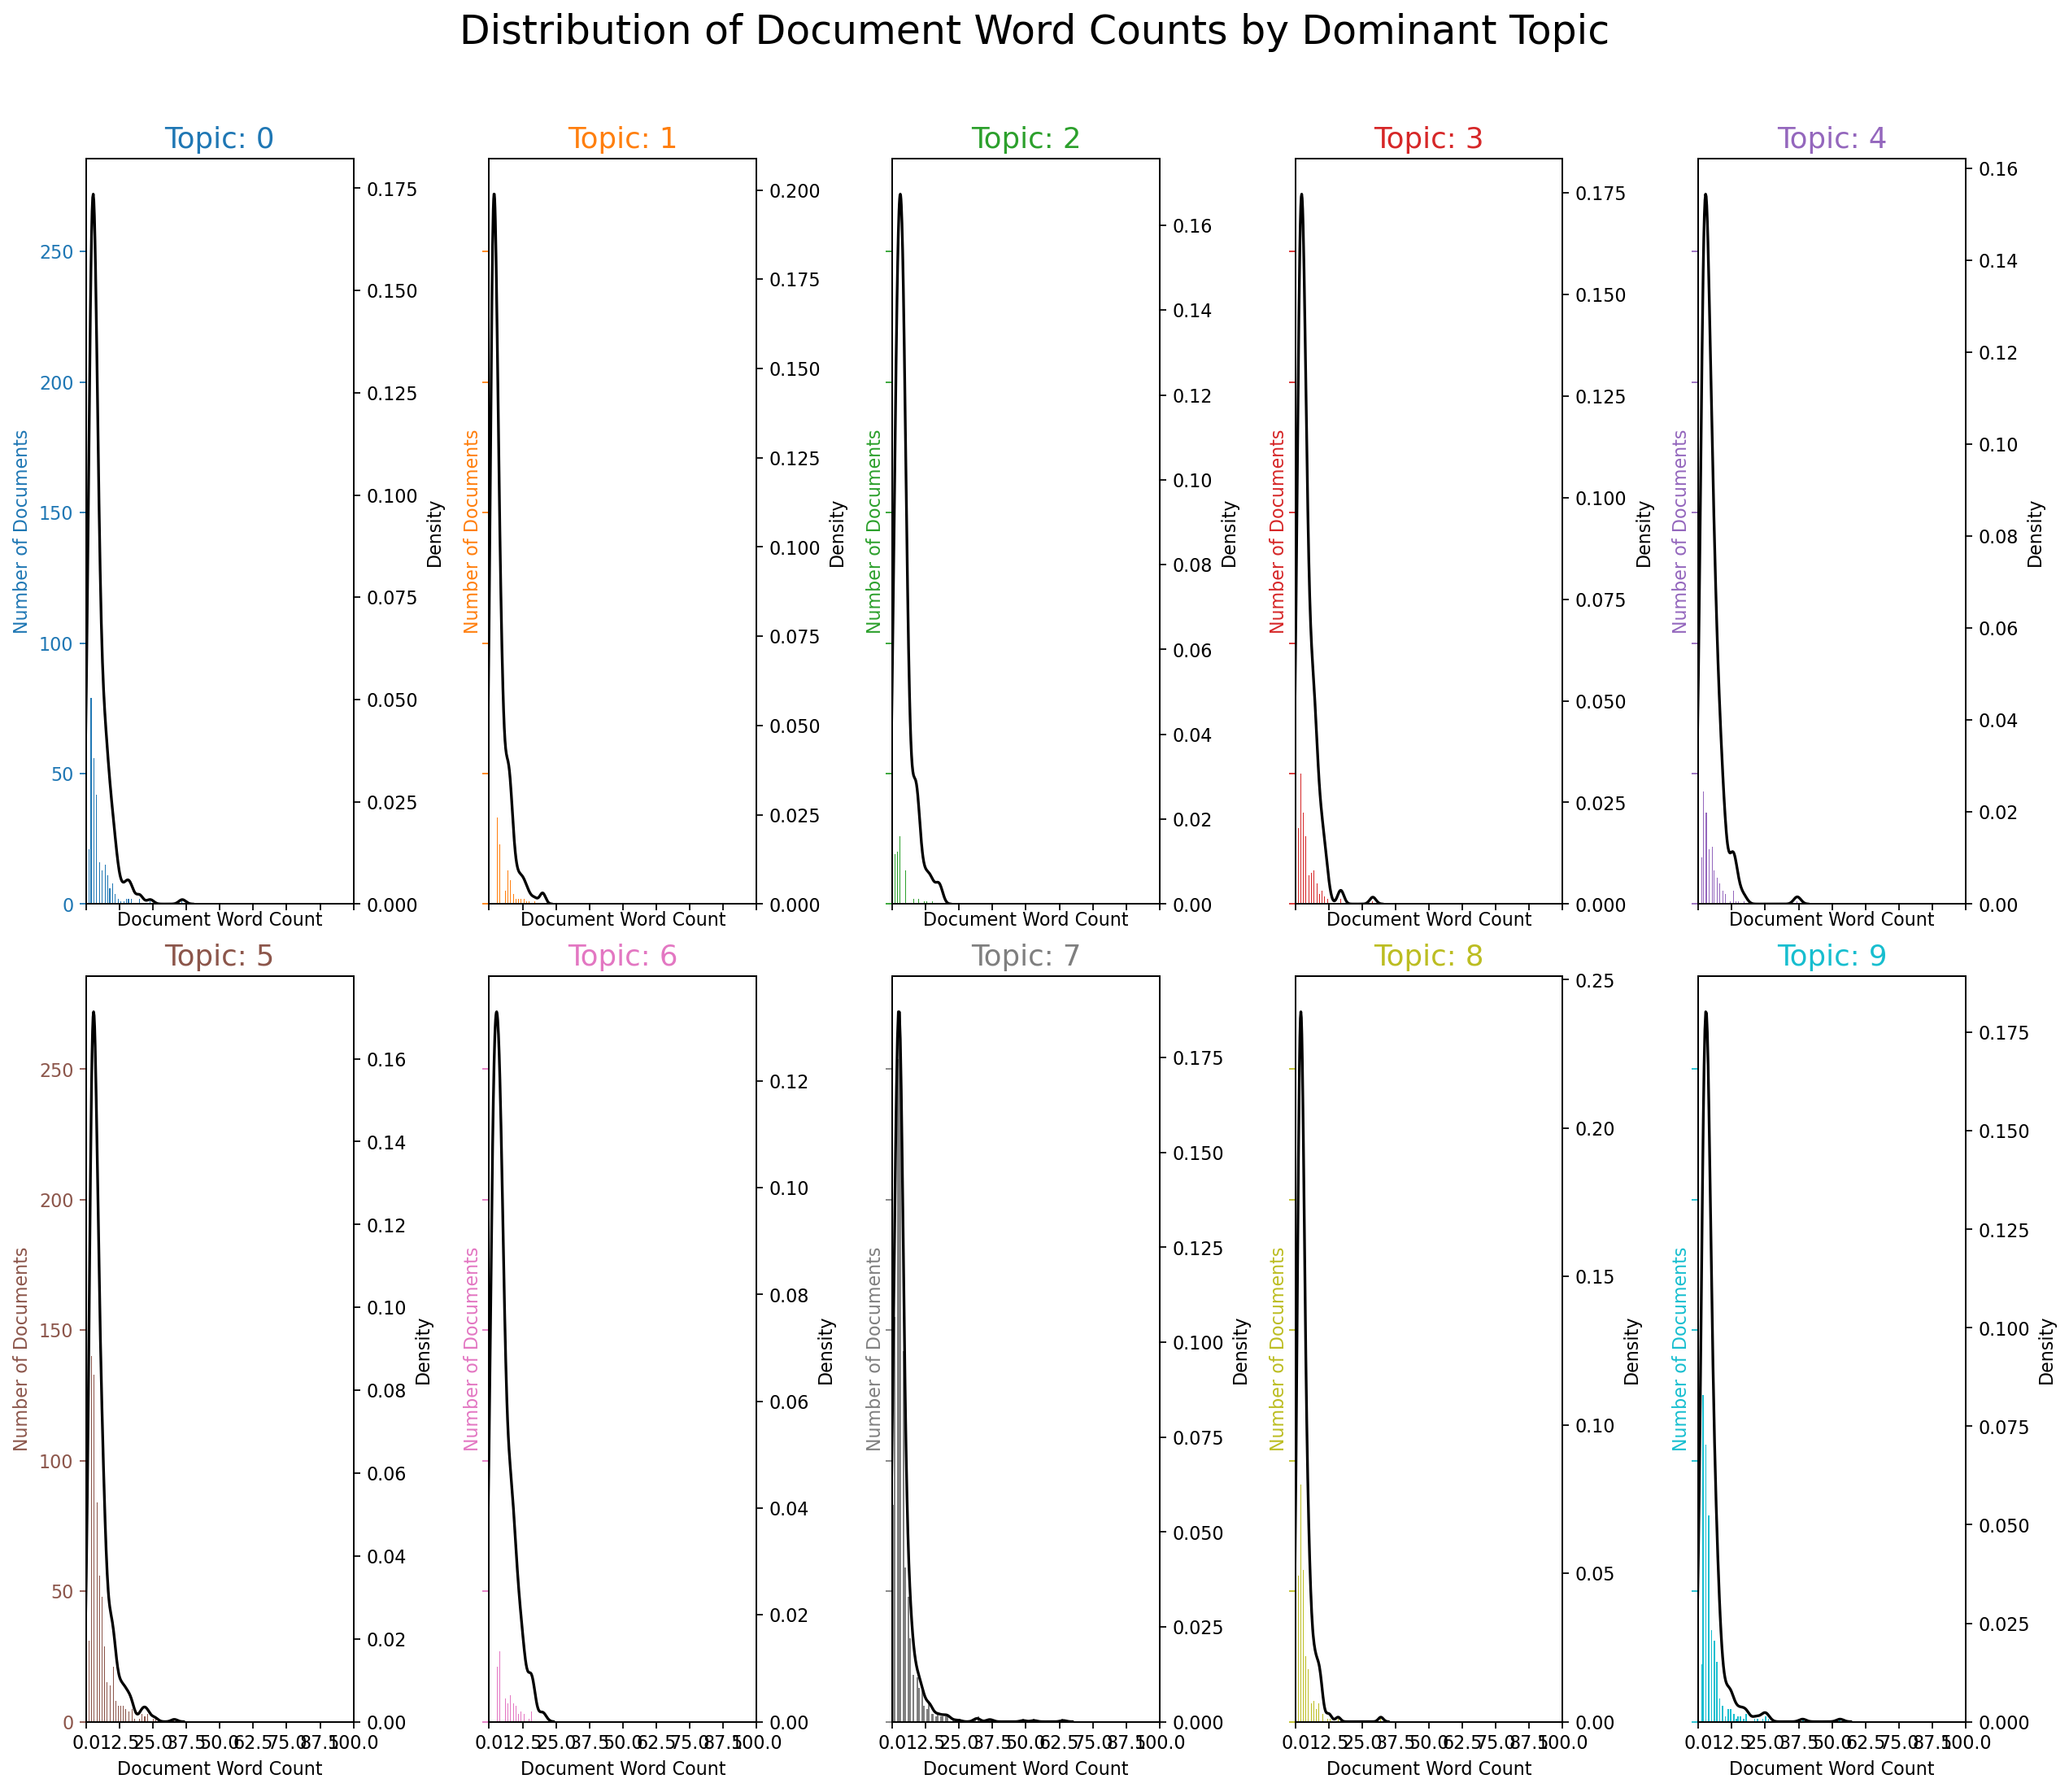

In [70]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,5,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\FM\A

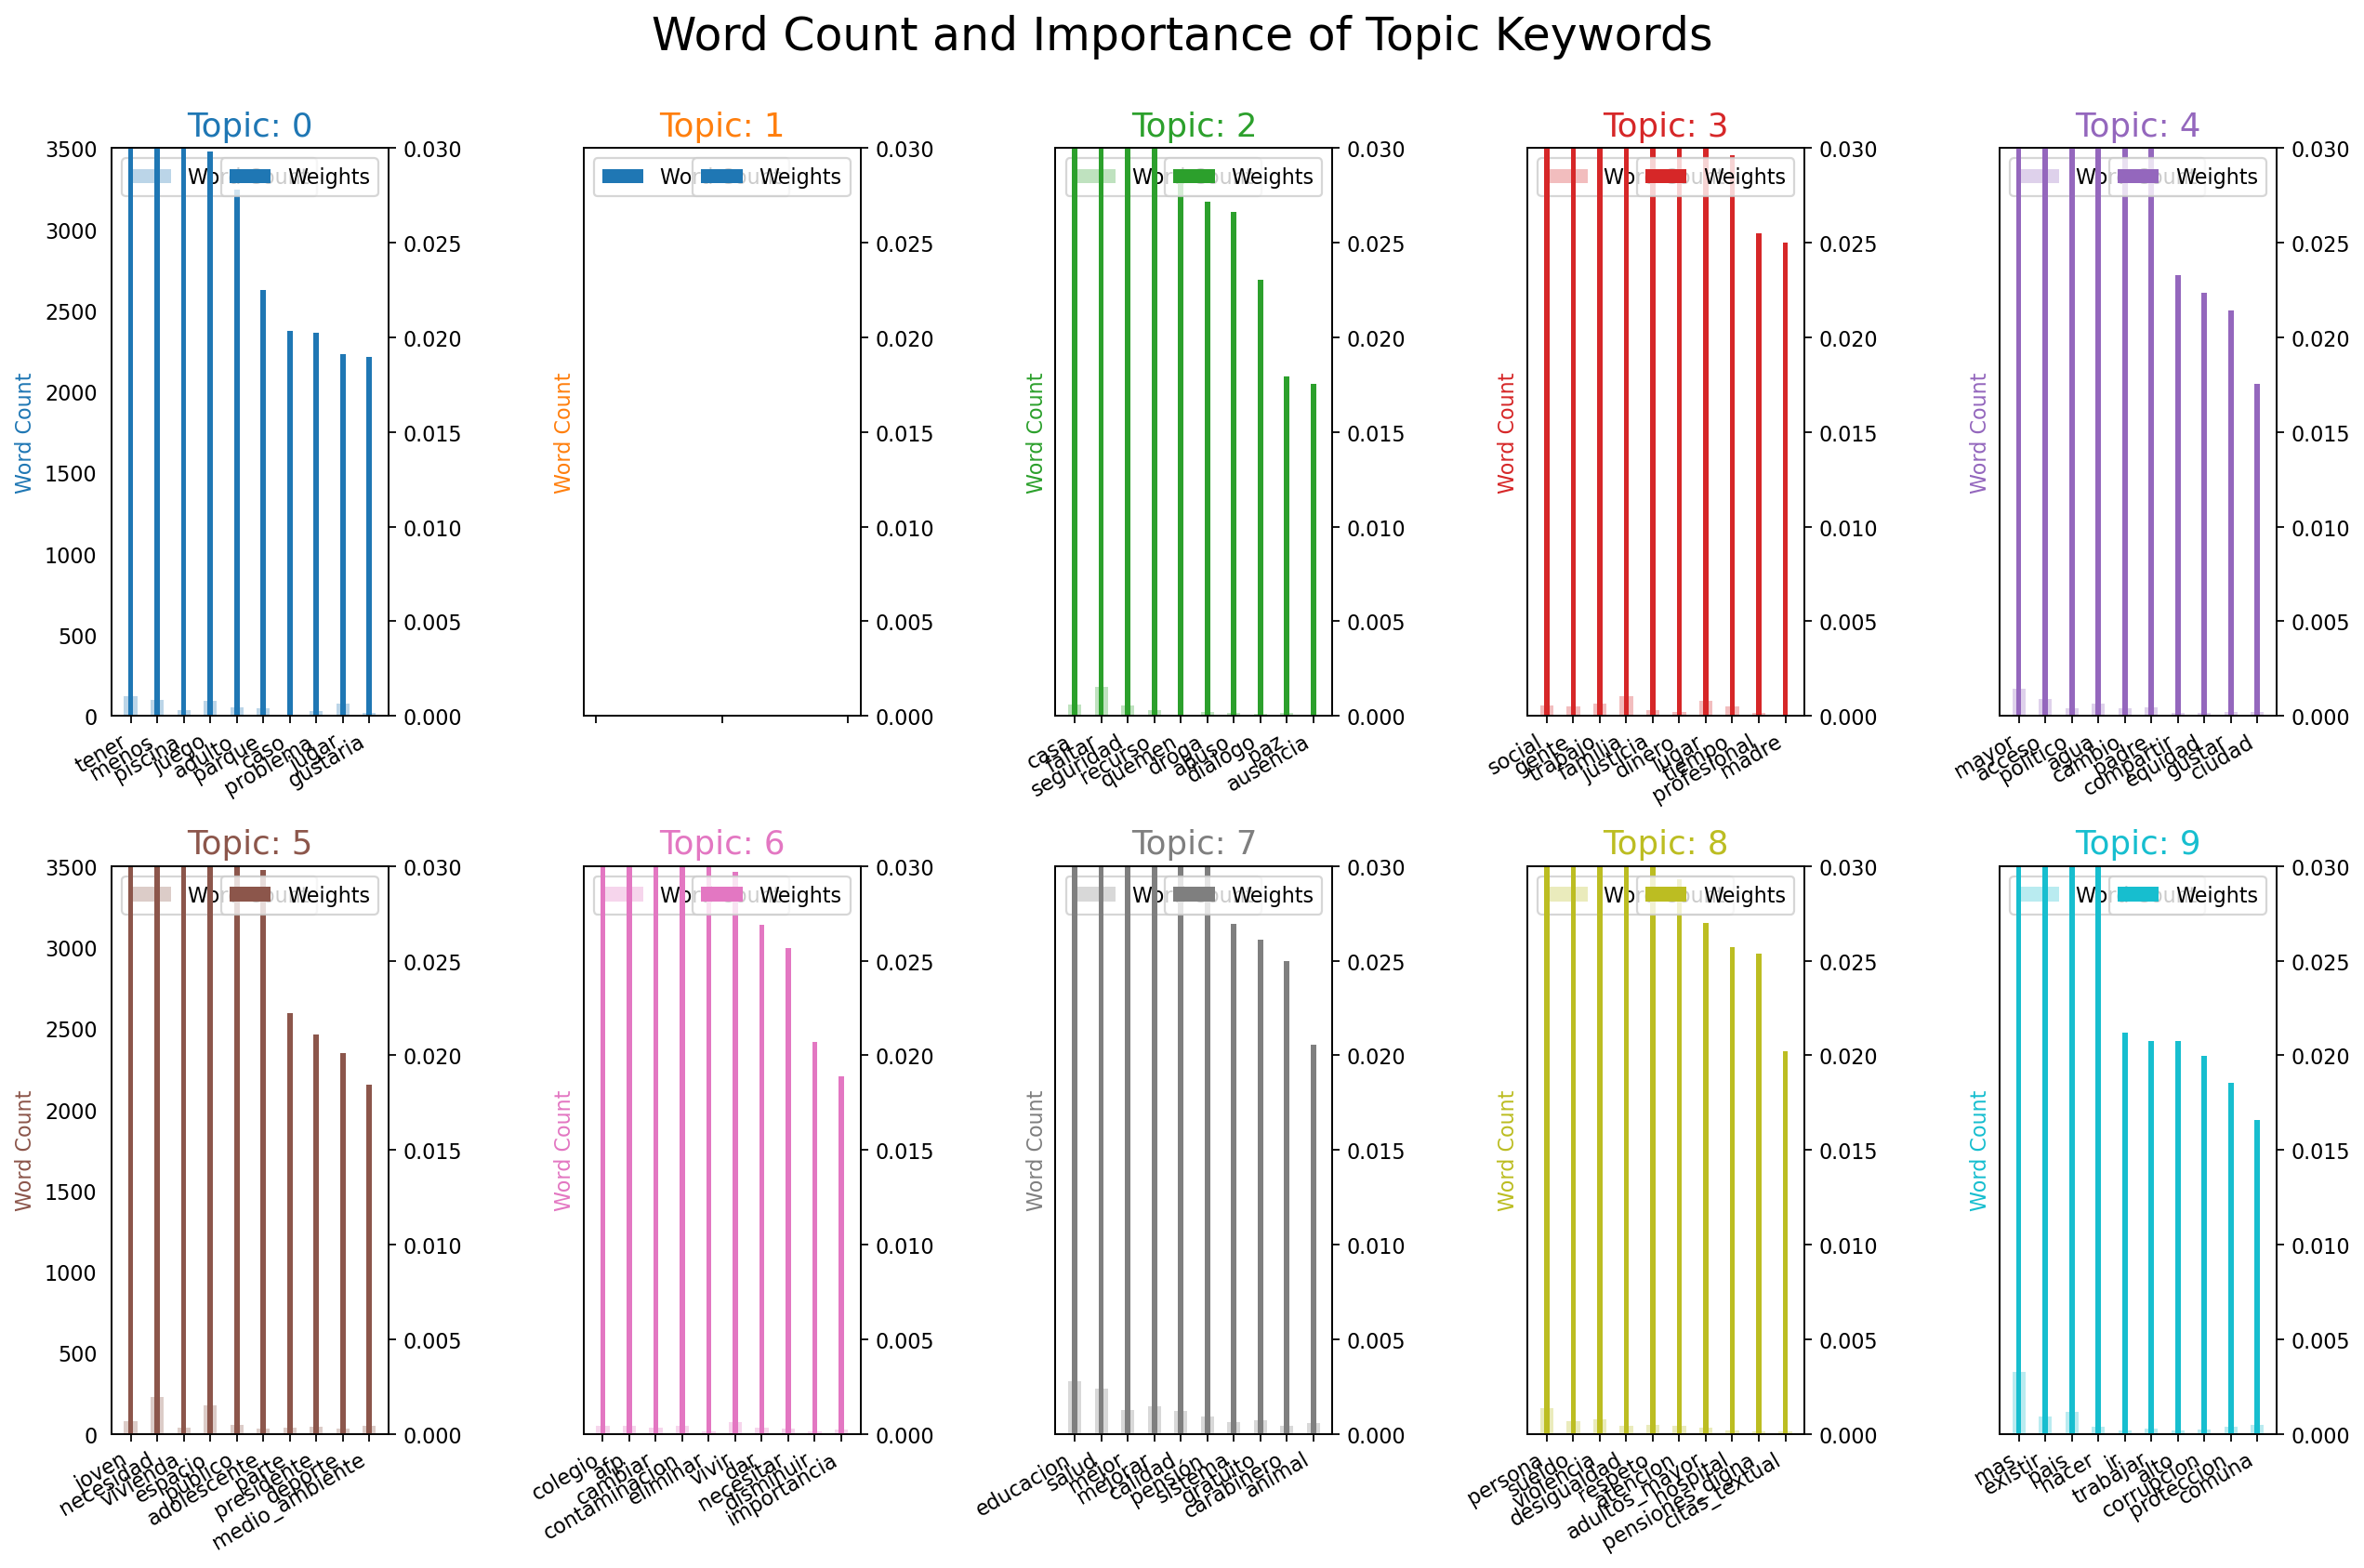

In [71]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 5, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

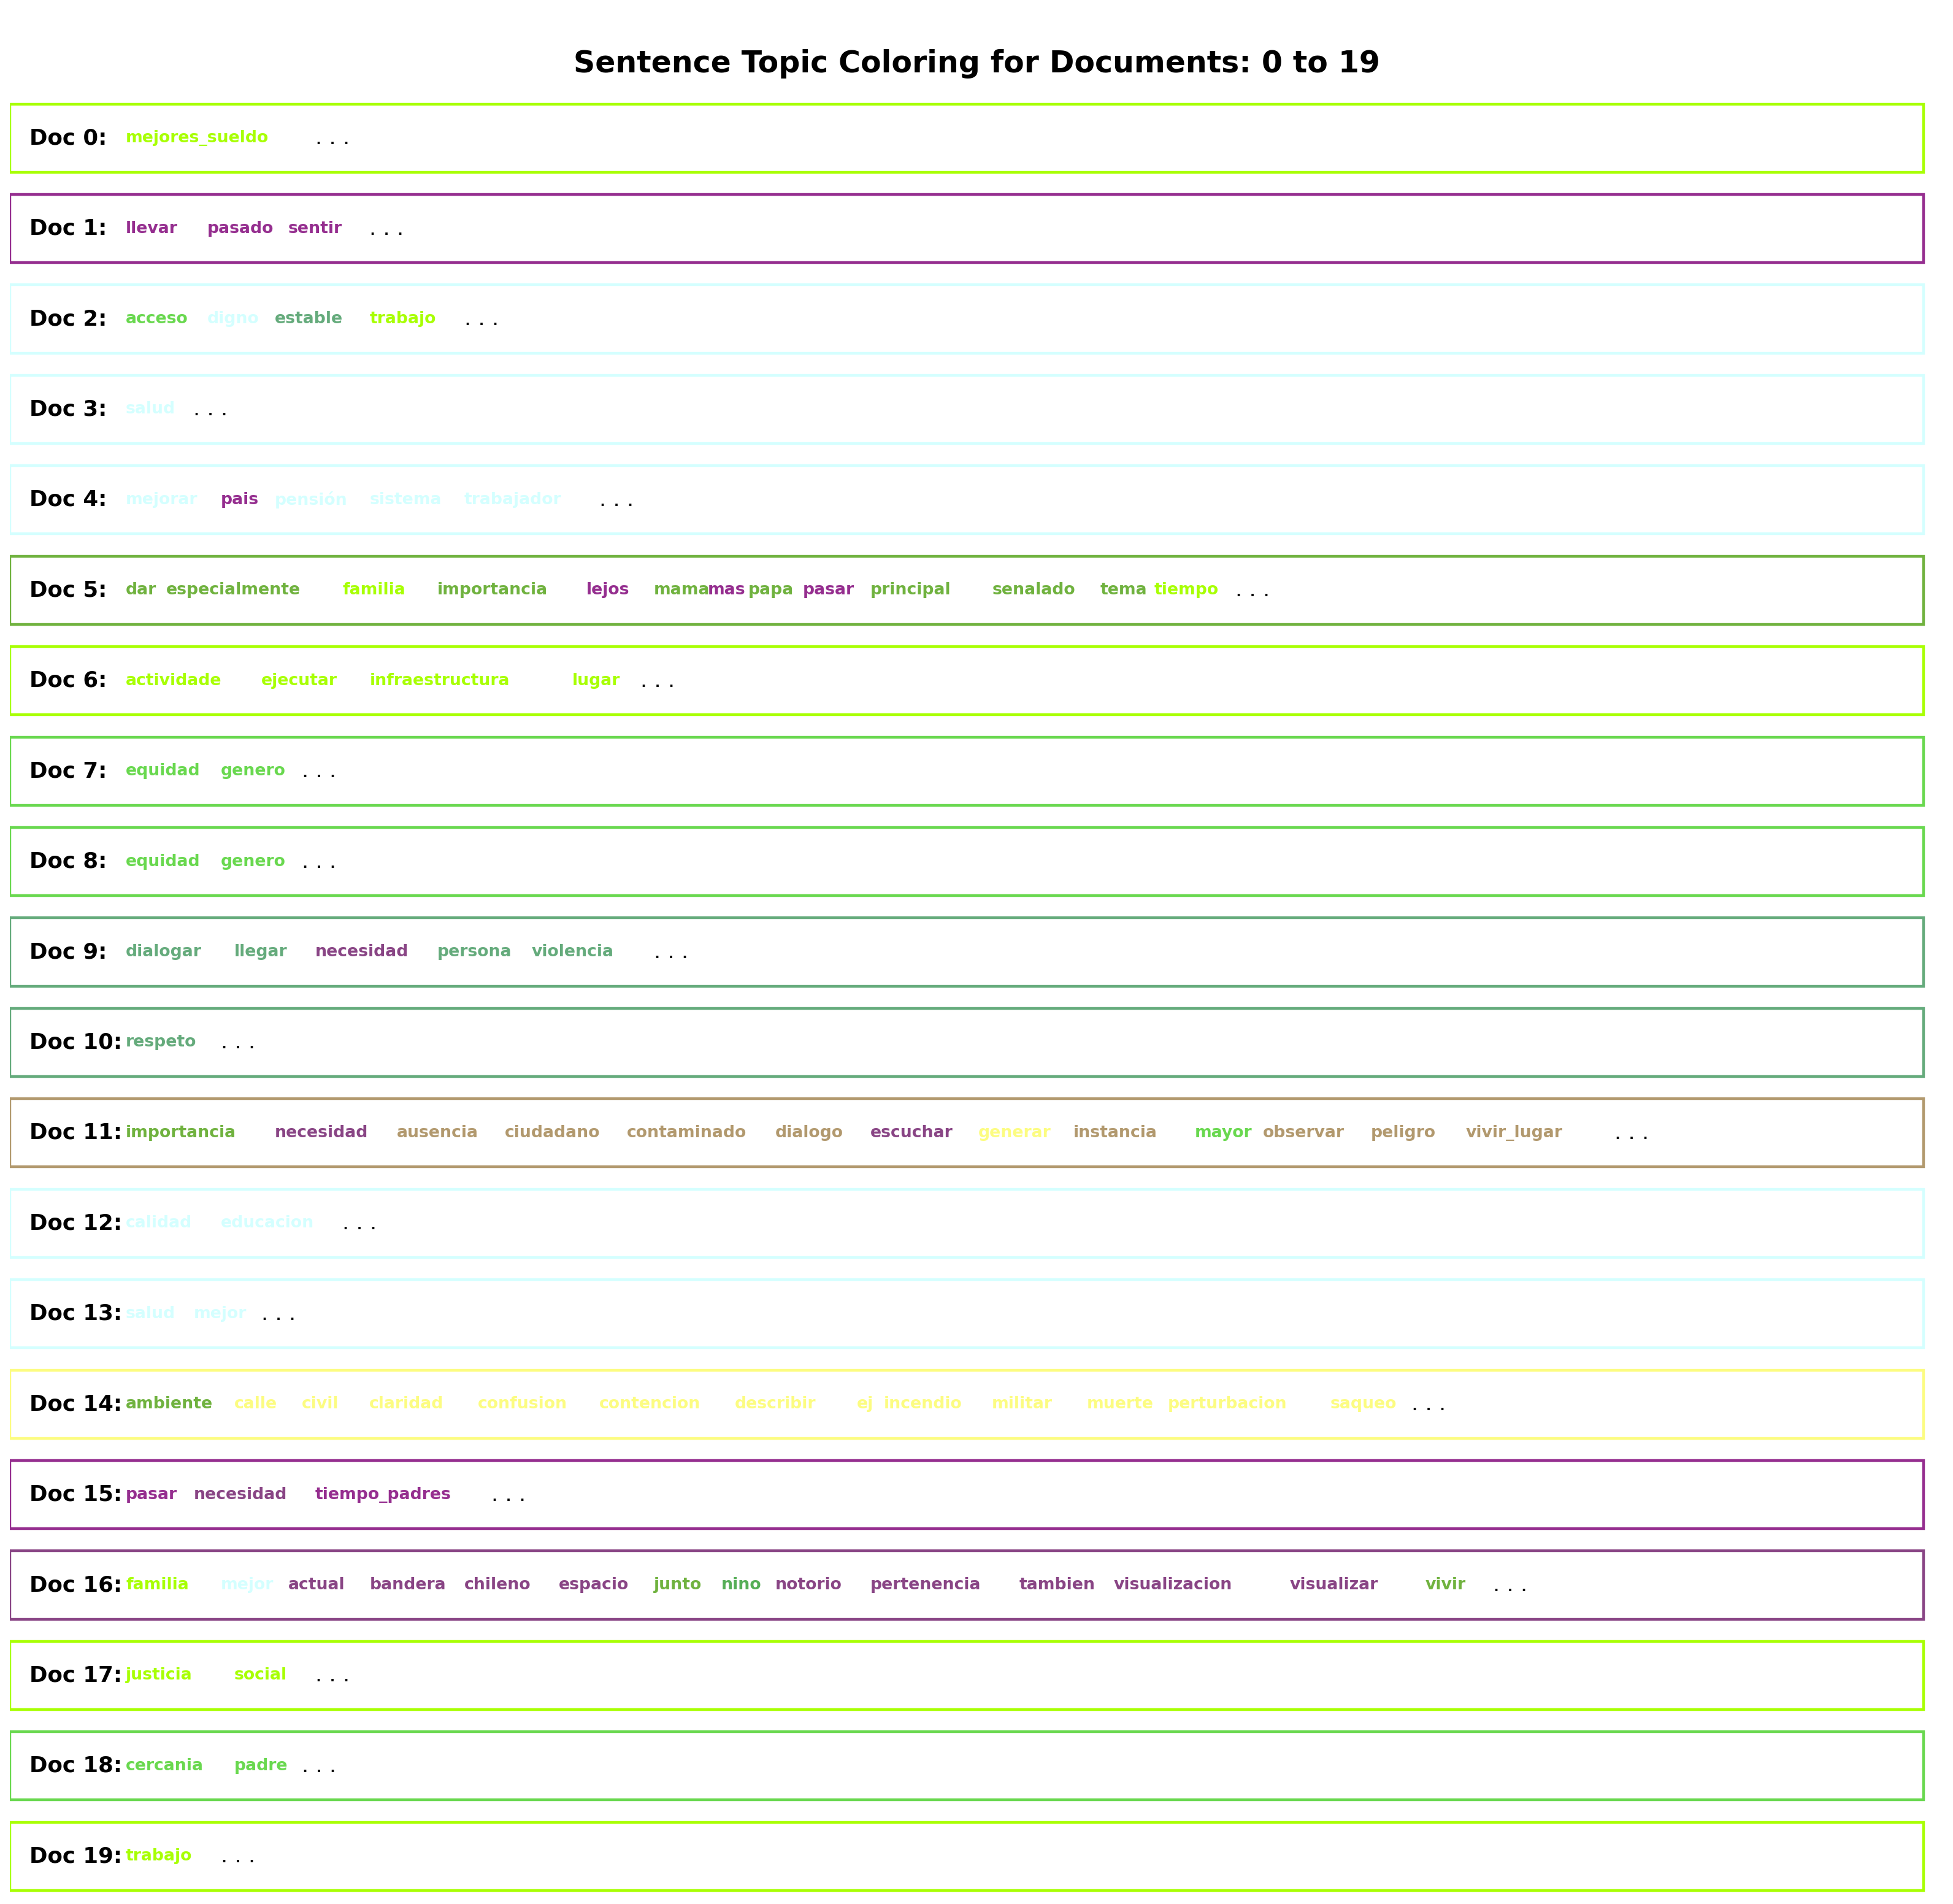

In [73]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 21):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.XKCD_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 18:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .007 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

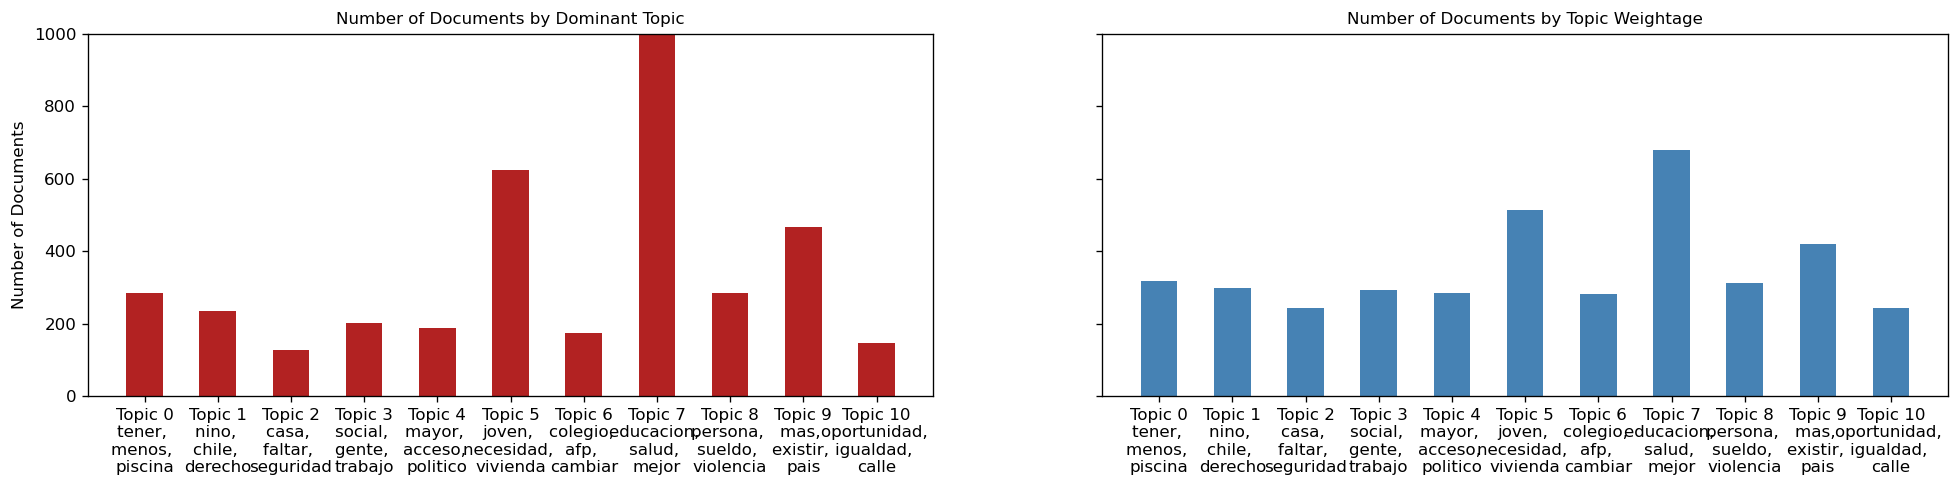

In [79]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(11,formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [77]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 11
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 646 samples in 0.001s...
[t-SNE] Computed neighbors for 646 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 646 / 646
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.758682
[t-SNE] KL divergence after 1000 iterations: 0.278420


Loading BokehJS ...

# Seleccionar por coherencia

In [46]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, a=0.01, b=0.1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
#        model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, 
#                                                num_topics=num_topics, random_state=100,alpha=a,eta=b,
#                                                chunksize=100,passes=10, per_word_topics=True)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, random_state=100,update_every=1,chunksize=128,passes=10,alpha='auto',eta='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=1)

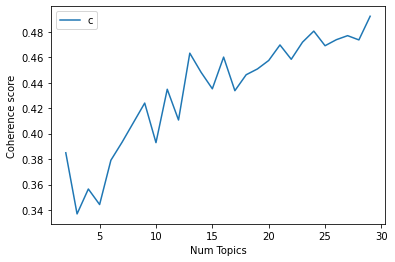

In [62]:
# Show graph
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

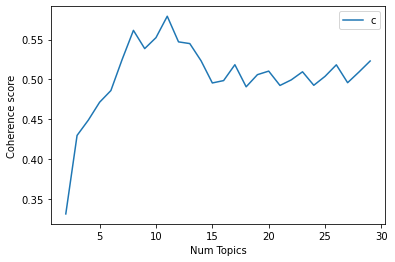

In [48]:
# Show graph
limit=30; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()